<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/A(11_1%EA%B0%95)AutoEncoder(%EB%84%A4%ED%81%AC%EC%9B%8C%ED%81%AC_%EC%9D%B4%EC%83%81%EC%A7%95%ED%9B%84_%ED%83%90%EC%A7%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0532 - val_loss: 0.0484
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0487 - val_loss: 0.0448
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 - val_loss: 0.0418
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459 - val_loss: 0.0389
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0423 - val_loss: 0.0358
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417 - val_loss: 0.0337
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - val_loss: 0.0319
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 - val_loss: 0.0303
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0375 - val_loss: 0.0292
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - val_loss: 0.0280
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - val_loss: 0.0270
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0345 - val_l

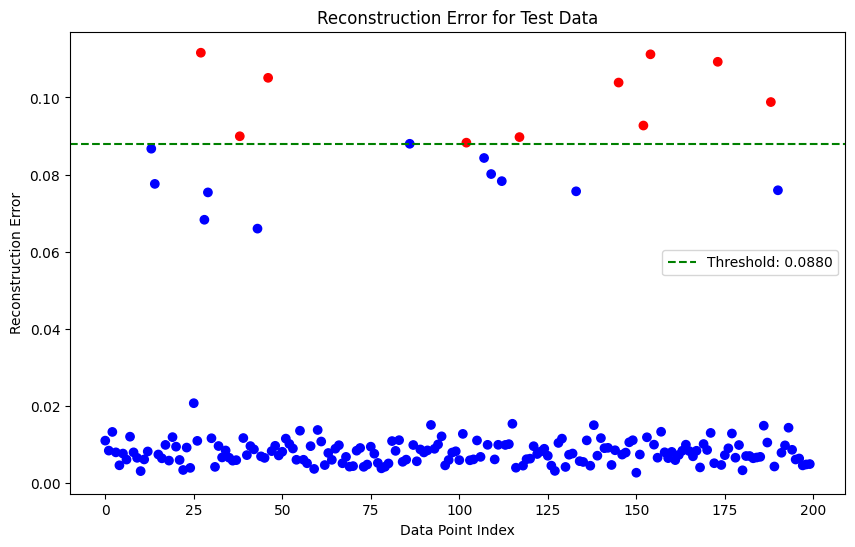

이상 징후 탐지 개수: 10
전체 데이터 중 이상 징후 비율: 5.00%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. 네트워크 데이터셋 생성 (정상 상태와 이상 징후를 시뮬레이션)
def generate_network_data(n_samples=1000, n_features=20, anomaly_fraction=0.1):
    normal_data = np.random.normal(loc=0.0, scale=1.0, size=(int(n_samples * (1 - anomaly_fraction)), n_features))
    anomaly_data = np.random.normal(loc=5.0, scale=1.0, size=(int(n_samples * anomaly_fraction), n_features))
    data = np.vstack([normal_data, anomaly_data])
    labels = np.hstack([np.zeros(int(n_samples * (1 - anomaly_fraction))), np.ones(int(n_samples * anomaly_fraction))])
    return data, labels

data, labels = generate_network_data()

# 데이터 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 2. 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

# 3. 오토인코더 모델 정의
input_dim = X_train.shape[1]
encoding_dim = 10  # 임의의 인코딩 차원

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 4. 오토인코더 학습 (잡음제거)
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)

# 5. 테스트 데이터에 대한 재구성 오차 계산
reconstructed_data = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - reconstructed_data, 2), axis=1)

# 6. 이상 징후 탐지 (재구성 오차가 임계값을 초과하는지 확인)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 임계값으로 설정
anomalies = reconstruction_error > threshold

# 7. 결과 시각화
plt.figure(figsize=(10,6))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=['r' if x else 'b' for x in anomalies])
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Error for Test Data")
plt.xlabel("Data Point Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

# 8. 이상 탐지 결과 출력
print(f"이상 징후 탐지 개수: {np.sum(anomalies)}")
print(f"전체 데이터 중 이상 징후 비율: {np.sum(anomalies) / len(anomalies) * 100:.2f}%")
